<u><b><b>**UCI BIKE SHARING DATA SET (Linear Regression)</b></b></u>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

Preprocessing/ EDA (Explotary Data Analysis)

In [2]:
hour_df = pd.read_csv('hour.csv')
print("shape of dataset is :", hour_df.shape)
hour_df.head()

shape of dataset is : (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
hour_df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

As mentioned in the documentation for the dataset, there are bike sharing as well as weather attributes available. The attribute dteday would require type conversion from object (or string type) to timestamp. Attributes like season, holiday, weekday, and so on are inferred as integers by pandas, and they would require conversion to categoricals for proper understanding.

In [4]:
# Before jumping into type casting attributes, the following snippet cleans up the attribute names to make them more understandable and pythonic.
hour_df.rename(columns={
    'instant' : 'rec_id',
    'dteday' : 'datetime',
    'holiday' : 'is_holiday',
    'workingday' : 'is_workingday',
    'weathersit' : 'weather_condition',
    'hum' : 'humidity',
    'mnth' : 'month',
    'cnt' : 'total_count',
    'hr' : 'hour',
    'yr' : 'year'}, inplace=True)

Now that we have attribute names cleaned up, we perform type-casting of attributes using utilities like pd.to_datetime() and astype(). The following snippet gets the attributes into proper data types .

In [5]:
# Date and time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# Categorigical Variables
# Categoricals are a pandas data type corresponding to categorical variables in statistics. A categorical variable takes on a limited, and usually fixed, number of possible values ( categories ; levels in R).
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')


Distribution And Trends

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

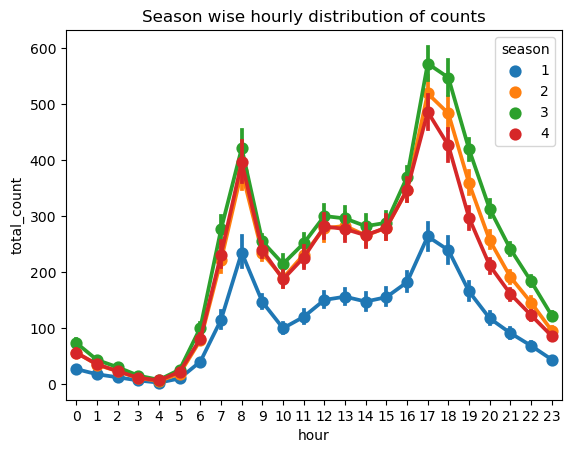

In [6]:
fig, ax = plt.subplots()
sn.pointplot(data = hour_df[['hour', 'total_count', 'season']], x='hour', y='total_count', hue='season', ax=ax)
ax.set(title="Season wise hourly distribution of counts")

[Text(0.5, 1.0, 'Weekdays wise hourly distribution of counts')]

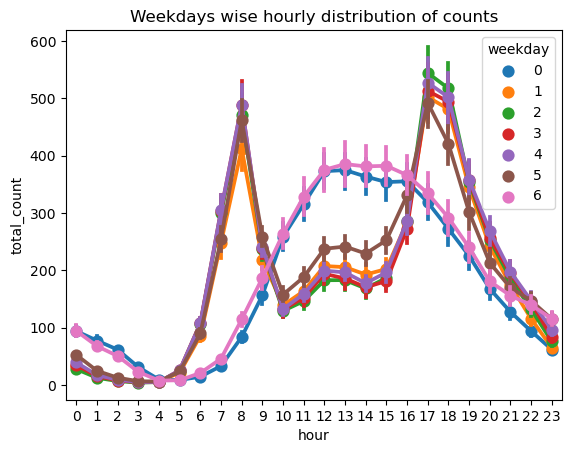

In [7]:
fig, ax = plt.subplots()
sn.pointplot(data= hour_df[['total_count', 'hour', 'weekday']], x='hour', y='total_count', hue='weekday', ax=ax)
ax.set(title="Weekdays wise hourly distribution of counts")

Similarly, distribution of ridership across days of the week also presents interesting trends of higher usage during afternoon hours over weekends, while weekdays see higher usage during mornings and evenings.

Having observed hourly distribution of data across different categoricals, let’s see if there are any aggregated trends.

[Text(0.5, 1.0, 'Monthly distribution of counts')]

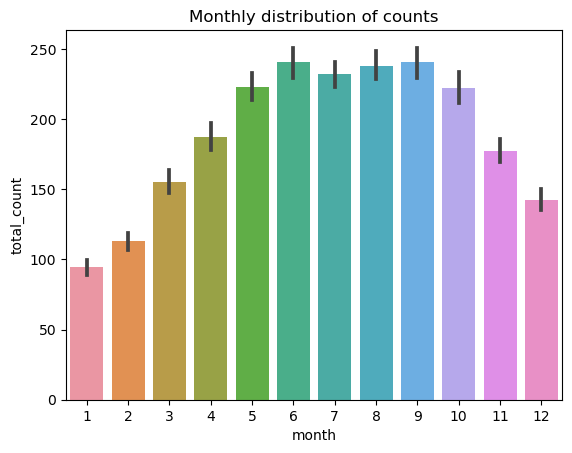

In [8]:
fig, ax = plt.subplots()
sn.barplot(data = hour_df[['month', 'total_count']], x='month', y='total_count')
ax.set(title="Monthly distribution of counts")

Moving up the aggregation level, let’s look at the distribution at year level. Our dataset contains year value of 0 representing 2011 and 1 representing 2012. We use a violin plot to understand multiple facets of this distribution in a crisp format.

<AxesSubplot:xlabel='year', ylabel='total_count'>

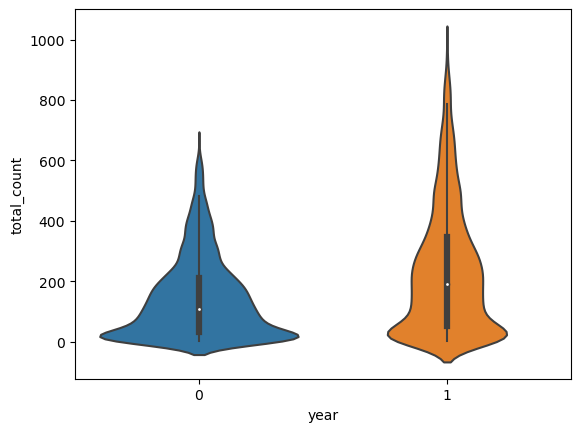

In [9]:
sn.violinplot(data=hour_df[['year', 'total_count']], x='year', y='total_count')

Figure above clearly helps us understand the multimodal distribution in both 2011 and 2012 ridership counts with 2011 having peaks at lowervalues as compared to 2012. The spread of counts is also much more for 2012, although the max density for both the years is between 100-200 rides.

<u><b>Outliers</b></u>

While exploring and learning about any dataset , it is imperative that we
check for extreme and unlikely values. Though we handle missing and
incorrect information while preprocessing the dataset, outliers are usually
caught during EDA. Outliers can severely and adversely impact the
downstream steps like modeling and the results.

We usually utilize boxplots to check for outliers in the data. In the following snippet, we analyze outliers for numeric attributes like total_count, temperature, and wind_speed.

<AxesSubplot:>

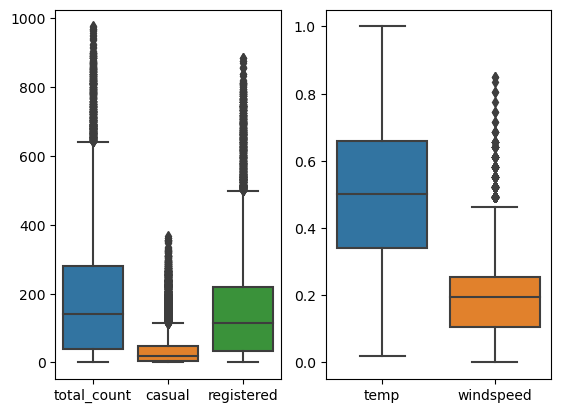

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sn.boxplot(data=hour_df[['total_count', 'casual', 'registered']], ax=ax1)
sn.boxplot(data=hour_df[['temp', 'windspeed']], ax=ax2)

The generated plot is shown in Figure above. We can easily mark out that for the three count related attributes, all of them seem to have a sizable number of outlier values. The casual rider distribution has overall lower numbers though. For weather attributes of temperature and wind speed, we find outliers only in the case of wind speed.

<AxesSubplot:xlabel='hour', ylabel='total_count'>

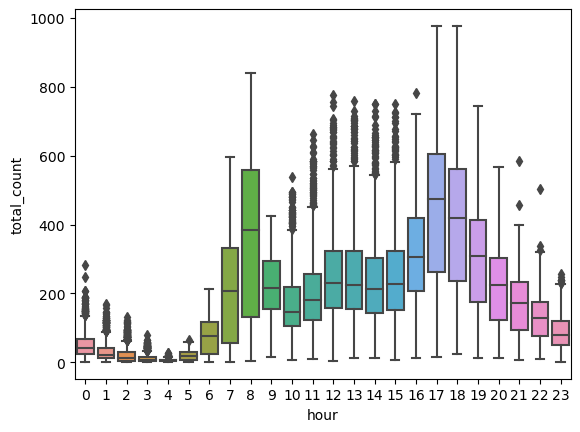

In [11]:
fig, ax3 = plt.subplots()
sn.boxplot(data=hour_df[['hour', 'total_count']],x='hour', y='total_count' ,ax=ax3)

We can similarly try to check outliers at different granularity levels like hourly, monthly, and so on. The visualization in Figure above showcases boxplots at hourly level, <b>*The above graph is extra one</b>

<b><u>Correlations</b></u>


Correlation helps us understand relationships between different attributes of the data. Since this chapter focuses on forecasting, correlations can help us understand and exploit relationships to build better models.

The following snippet first prepares a correlational matrix using the
pandas utility function corr(). It then uses a heat map to plot the
correlation matrix.

<AxesSubplot:>

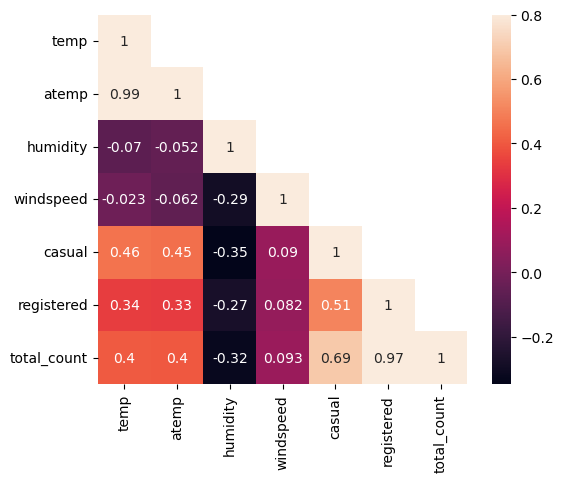

In [12]:
corrMatrix = hour_df[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'total_count']].corr()
mask = np.array(corrMatrix)
mask[np.tril_indices_from(mask)] = False
sn.heatmap(corrMatrix, mask=mask, vmax=.8, square=True, annot=True)

Figure above shows the output correlational matrix (heat map) showing values in the lower triangular form on a blue to red gradient (negative to positive correlation).

The two count variables, registered and casual, show obvious strong correlation to total_count. Similarly, temp and atemp show high correlation. wind_speed and humidity have slight negative correlation. Overall, none of the attributes show high correlational statistics.

<u><b>Regression Analysis</b></u>

Regression analysis is a statistical modeling technique used by statisticians and Data Scientists alike. It is the process of investigating relationships between dependent and independent variables. Regression itself includes a variety of techniques for modeling and analyzing relationships between variables. It is widely used for predictive analysis, forecasting, and time series analysis.

The dependent or target variable is estimated as a function of independent or predictor variables. The estimation function is called the regression function.

In [13]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified column.
    Args: df(pandas.DataFrame): the data frame containing the mentioned column name
    col_name: the column to be one hot encoded
    Returns: tuple: label_encoder, one_hot_encoder, transformed column as pandas Series """

    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels

    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

<b>Here, The terminology used is:</b>
    </br>1. One-hot encoding is used in machine learning as a method to quantify categorical data. In short, this method produces a vector with length equal to the number of categories in the data set.
    </br>Example: [0,1,0,0] // female,  [1,0,0,0] // male, [0,0,1,0] // gender-neutral
    </br>2. Label Encoding refers to converting the labels into a numeric form so as to convert them into the machine-readable form. Machine learning algorithms can then decide in a better way how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.</br>
-->We use the fit_transform_ohe() function along with transform_ohe() to encode the categoricals. The Label and One Hot
encoders are available as part of scikit-learn’s preprocessing module.</br>
-->Both scikit-leran and sklearn are same, The only difference is that the one is the dummy package of the other, But they do the same thing only.

In [14]:
x, x_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:, -1], test_size=0.33, random_state=42)
x.reset_index(inplace=True)
y = y.reset_index()

x_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [15]:
# The following snippent loops through the list of categorigical variables to transform and prepare a list of encoded attributes
cat_attr_list = ['season', 'is_holiday', 'weather_condition', 'hour', 'weekday', 'month', 'year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(x, col)
    encoded_attr_list.append({'label_enc': return_obj[0],
                             'ohe_enc': return_obj[1],
                             'feature_df': return_obj[2],
                             'col_name': col})

Next, we merge the numeric and one hot encoded categoricals into a dataframe that we will use for our modeling purposes. The following snippet helps us prepare the required dataset.

In [16]:
print(encoded_attr_list)

[{'label_enc': LabelEncoder(), 'ohe_enc': OneHotEncoder(), 'feature_df':        season_1  season_2  season_3  season_4
0           0.0       0.0       1.0       0.0
1           0.0       1.0       0.0       0.0
2           0.0       0.0       1.0       0.0
3           1.0       0.0       0.0       0.0
4           0.0       1.0       0.0       0.0
...         ...       ...       ...       ...
11638       0.0       1.0       0.0       0.0
11639       0.0       1.0       0.0       0.0
11640       0.0       0.0       1.0       0.0
11641       1.0       0.0       0.0       0.0
11642       0.0       0.0       0.0       1.0

[11643 rows x 4 columns], 'col_name': 'season'}, {'label_enc': LabelEncoder(), 'ohe_enc': OneHotEncoder(), 'feature_df':        is_holiday_0  is_holiday_1
0               1.0           0.0
1               1.0           0.0
2               1.0           0.0
3               1.0           0.0
4               1.0           0.0
...             ...           ...
11638          

Next, we merge the numeric and one hot encoded categoricals into a dataframe that we will use for our modeling purposes. The following snippet helps us prepare the required dataset.

Note Though we have transformed all categoricals into their one-hot encodings, note that ordinal attributes such as hour, weekday, and so on do not require such encoding.

In [17]:
feature_df_list = [x[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] for enc in encoded_attr_list if enc['col_name'] in subset_cat_features])
train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape :: {}".format(train_df_new.shape))

Shape :: (11643, 17)


We prepared a new dataframe using numeric and one hot encoded categorical attributes from the original training dataframe. The original dataframe had 10 such attributes (including both numeric and categoricals). Post this transformation, the new dataframe has 19 attributes due to one hot encoding of the categoricals.

In [18]:
x = train_df_new
y = y.total_count.values.reshape(-1, 1)
lin_reg = linear_model.LinearRegression()

predicted = cross_val_predict(lin_reg, x, y, cv=10)

This function takes the model object, predictors, and targets as inputs. We specify the k in k-fold using the
cv parameter. In our example, we use 10-fold cross validation. This function returns cross validated prediction values as fitted by the model object.</br>

-->We use scatter plot to analyze our predictions . The following snippet uses matplotlib to generate scatter plot between residuals and observedvalues.

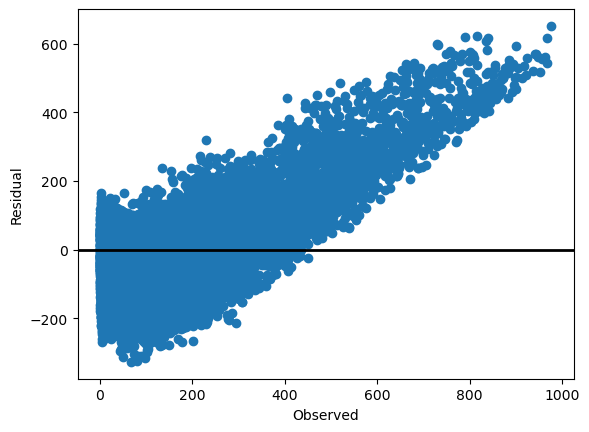

In [19]:
fig, ax = plt.subplots()
ax.scatter(y, y-predicted)
ax.axhline(lw=2, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

--> -1 in reshape function is used when you dont know or want to explicitly tell the dimension of that axis. E.g,
If you have an array of shape (2,4) then reshaping it with (-1, 1), then the array will get reshaped in such a way that the resulting array has only 1 column and this is only possible by having 8 rows, hence, (8,1).

The plot in Figure above clearly violates the homoscedasticity assumption, which is about residuals being random and not following any pattern. To further quantify our findings related to the model, we plot the cross-validation scores. We use the cross_val_score() function available again as part of the model_selection module, which is
shown in the visualization in Figure below.

In [20]:
r2_scores = cross_val_score(lin_reg, x, y, cv=10)
mse_scores = cross_val_score(lin_reg, x, y, cv=10, scoring='neg_mean_squared_error')

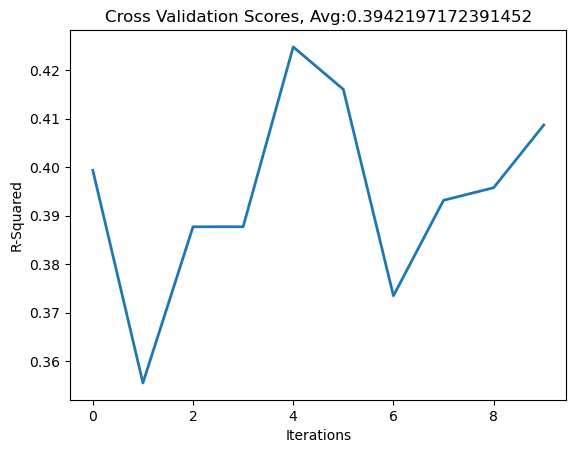

In [21]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))], r2_scores, lw=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [22]:
lin_reg.fit(x, y)

LinearRegression()

<b><b><u>Testing</u></b></b>
</br>But before we can use the test dataset on the learned regression line, we need to make sure the attributes have been through the same preprocessing in both training and testing sets. Since we transformed categorical variables into their one hot encodings in the train dataset, in the following snippet we perform the same actions on the test dataset as well.

In [23]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(x_test, le,ohe, col_name), 'col_name':col_name})
    
test_feature_df_list = [x_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] for enc in test_encoded_attr_list if enc['col_name'] in subset_cat_features])
test_df_new = pd.concat(test_feature_df_list, axis=1)

print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 17)


In [24]:
test_df_new.head()

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4
0,0.80,0.27,0.1940,19,6,6,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.24,0.41,0.2239,20,1,1,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.32,0.66,0.2836,2,5,10,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.78,0.52,0.3582,19,2,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.26,0.56,0.3881,0,4,1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [25]:
x_test = test_df_new
y_test = y_test.total_count.values.reshape(-1, 1)
y_pred = lin_reg.predict(x_test)
residuals = y_test-y_pred

In [26]:
r2_score = lin_reg.score(x_test, y_test)
print("R-Squared :: {}".format(r2_score))
print("MSE : %.2f" % metrics.mean_squared_error(y_test, y_pred))

R-Squared :: 0.40243724440588713
MSE : 19063.12


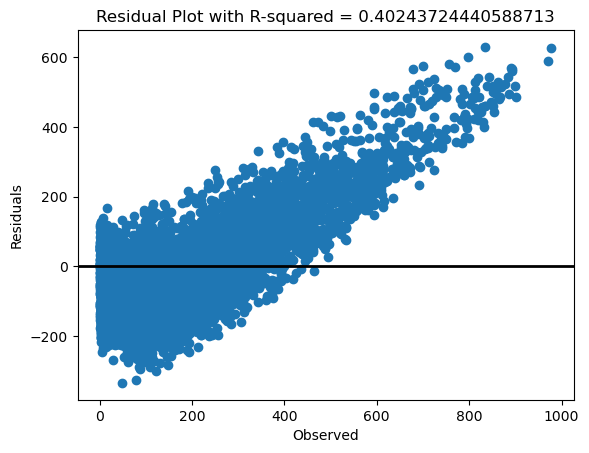

In [27]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot with R-squared = {}".format(np.average(r2_score)))
plt.show()

It is clearly evident from our evaluation that the linear regression model is unable to model the data to generate decent results. Though it should be noted that the model is performing equally on both training and testing datasets. It seems like a case where we would need to model this data using methods that can model non-linear relationships.